<a href="https://colab.research.google.com/github/deniz2104/Anomaly-Detector/blob/main/Proiect_anomalii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectarea anomaliilor intr-un set de date bazat pe temperaturi
## Setul de date contine 3650 de randuri cu temperaturi diverse in intervalul: 1/1/1981 - 12/31/1990
### Proiectul se focuseaza asupra detectarea anomaliilor folosind metode si grafice relevante pentru setul de date.

#Importarea bibliotecilor necesare




In [1]:
!pip install pyod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.ocsvm import OCSVM
from pyod.models.abod import ABOD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score
from scipy.spatial.distance import euclidean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=ac594777de84cb907607cfbb5d746b23672b5e6838714240b7e5e3a16f0099eb
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


#Incarcarea datelor si preprocesarea datelor in caz de nevoie
## Se poate observa ca setul de date nu contine date nule sau lipsa.




In [2]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    if data.isnull().values.any():
      print("There are null values in the dataset.")
    else:
      print("No null values in the dataset.")

    print("\n")
    return data

#Explorarea setului de date prin multiple functii pentru a vizualiza caracteristicile acestuia
### Pentru un set de date simplu prezent doar din date cu temperaturi asociate ne pot interesa temperaturile maxime si minime,cat si datele medii pentru a intui care vor fi anomaliile.

In [3]:
def display_basic_statistics(data):
    #Displaying general information about the dataset
    print("General Statistics:")
    print("\n")
    print(data.info())
    print("\n")


    #Displaying the first few rows of the dataset
    print("First Few Rows:")
    print("\n")
    print(data.head)
    print("\n")


    # Check for missing data
    print("Missing Data:")
    print("\n")
    print(data.isnull().sum())
    print("\n")


    # Minimum and maximum for 'Temp' column
    print("Temperature Statistics:")
    print("\n")
    print(f"Min: {data['Temp'].min()}, Max: {data['Temp'].max()}")
    print("\n")


    print("Basic Statistics:")
    print("\n")
    print(data['Temp'].describe())
    print("\n")

# Afisarea graficelor reprezentand varierea temperaturii de-alungul timpului,cat si o histograma pentru a prezenta frecventa cu care apar temperaturile.
## Anomaliile aparute in cadrul setului de date sunt locale.Se pot observa ca anumite temperaturi sunt deviate de la medie,fie mai ridicate,fie mai scazute.

In [4]:
def plot_temperature_trend_and_temperature_distribution(data):

    plt.figure(figsize=(12, 6))
    plt.scatter(data['Date'], data['Temp'], label='Min Temperature', color='blue', linewidth=0.6)
    plt.title('Temperature Over Time', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature(°C)', fontsize=12)
    plt.show()
    print("\n")

    plt.figure(figsize=(12, 6))
    plt.hist(data['Temp'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Temperature Distribution', fontsize=16)
    plt.xlabel('Temperature (°C)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()
    print("\n")


#Folosirea metodei One Class SVM pentru detectarea anomaliilor
## Scurta descriere a metodei:
### Se bazeaza pe identificarea unei majoritati (o multitudine de puncte) in cadrul unui set de date care sunt separate de potentialele anomalii.
###Mai concret,se defineste o frontiera marginala prin intermediul unui kernel si prin intermediul hiperparametrului "nu" care controleaza cate anomalii sunt permise.

##Avantaje:
- Versatil (tipurile de kernel pot fi adapdate pentru diverse seturi de date specifice).
- Nu este nevoie de label-uri.

##Dezavantaje:
- Sensibil la parametrii (parametrii "nu" si "gamma" trebuie sa fie ajustati concret pentru o antrenare specifica).


In [5]:

def detect_anomalies_ocsvm(data, contamination=0.1, kernel='rbf', gamma='scale', nu=0.5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[['Temp']])

    clf = OCSVM(contamination=contamination, kernel=kernel, gamma=gamma, nu=nu)
    clf.fit(X_scaled)

    data['Anomaly'] = clf.predict(X_scaled)
    return data

#Graficul normal alaturi de cel cu anomalii,anomalii fiind prezente prin culoarea rosie.

In [6]:
def plot_anomalies(data,title):
    anomaly = data[data['Anomaly'] == 1]
    normal = data[data['Anomaly'] == 0]

    plt.figure(figsize=(14, 7))
    plt.scatter(normal['Date'], normal['Temp'], label='Normal', color='blue', alpha=0.6)
    plt.scatter(anomaly['Date'], anomaly['Temp'], color='red', label='Anomaly', zorder=3)
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Temperature (°C)', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()
    print("\n")


#Implementarea unei clase de test pentru metoda One Class SVM pentru tratarea mai multor parametrii

In [7]:
def test_ocsvm_with_params(data, params_list):
        results=[]
        for params in params_list:
          contamination = params.get('contamination', 0.1)
          kernel = params.get('kernel', 'rbf')
          nu = params.get('nu', 0.5)
          gamma = params.get('gamma', 'scale')

          processed_data = detect_anomalies_ocsvm(data.copy(), contamination=contamination, kernel=kernel, nu=nu, gamma=gamma)

          title = f"OCSVM (Kernel={kernel}, Contamination={contamination}, Nu={nu}, Gamma={gamma})"
          plot_anomalies(processed_data, title)

          np.random.seed(42)
          y_true = np.random.choice([0, 1], size=len(data), p=[1-contamination, contamination])
          y_pred = processed_data['Anomaly']

          metrics = evaluate_performance(y_true, y_pred)

          results.append({"config": params, "metrics": metrics})

        return results


#Folosirea metodei KNN pentru detectarea anomaliilor

##Scurta descriere:
###KNN clasifică un punct nou pe baza clasei majoritare a celor mai apropiați k vecini.
##Functionare:
- Se calculează distanța dintre punctul nou și toate punctele din setul de date.
- Se selecteaza cei mai apropiati k vecini.
- Se atribuie noului punct clasa majoritara.

##Avantaje:
- performanta buna cand datele sunt de dimensiuni mici.
- performanta buna cand datale sunt bine distribuite.

##Dezavantaje:
- sensibila la zgomot.

In [8]:
from pyod.models.knn import KNN
def detect_anomalies_knn(data, contamination=0.1, n_neighbors=20, metric='euclidean'):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[['Temp']])

    knn_model = KNN(contamination=contamination, n_neighbors=n_neighbors, metric=metric)
    knn_model.fit(X_scaled)

    y_pred = knn_model.labels_

    data['Anomaly'] = y_pred
    return data

# Implementarea unei clase de test pentru metoda KNN cu mai multi parametrii diferiti

In [9]:
def test_knn_with_params(data, params_list):
    results = []
    for params in params_list:
        contamination = params.get('contamination', 0.1)
        n_neighbors = params.get('n_neighbors', 20)
        metric = params.get('metric', 'euclidean')

        processed_data = detect_anomalies_knn(data.copy(), contamination, n_neighbors, metric)

        title = f"KNN Anomalies (Contamination={contamination}, Neighbors={n_neighbors}, Metric={metric})"
        plot_anomalies(processed_data, title)

        np.random.seed(42)
        y_true = np.random.choice([0, 1], size=len(data), p=[1 - contamination, contamination])
        y_pred = processed_data['Anomaly']

        metrics = evaluate_performance(y_true, y_pred)

        results.append({"config": params, "metrics": metrics})

    return results

#Folosirea metodei LODA pentru detectarea anomaliilor

##Scurta descriere:
###LODA proiecteaza datale pe mai multe axe unidimensionale alese aleator.
###In fiecare proiectie,algoritmul face o histograma pentru a estima densitatea datelor.

##Avantaje:
- scalabil si rapid
- poate procesa fluxuri de date in timp real

##Dezavantaje:
- sensibil la parametrizare

In [12]:
from pyod.models.loda import LODA

def detect_anomalies_loda(data, contamination=0.1, n_bins=10):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[['Temp']])

    clf = LODA(contamination=contamination, n_bins=n_bins)
    clf.fit(X_scaled)

    data['Anomaly'] = clf.predict(X_scaled)
    return data


# Implementarea unei functii de test pentru LODA

In [13]:
def test_loda_with_params(data, params_list):
    results = []
    for params in params_list:
        contamination = params.get('contamination', 0.1)
        n_bins = params.get('n_bins', 10)

        anomalies = detect_anomalies_loda(data.copy(), contamination=contamination, n_bins=n_bins)

        title = f"LODA Anomalies (Contamination={contamination}, Bins={n_bins})"
        plot_anomalies(anomalies, title)

        np.random.seed(42)
        y_true = np.random.choice([0, 1], size=len(data), p=[1 - contamination, contamination])
        y_pred = anomalies['Anomaly']

        metrics = evaluate_performance(y_true, y_pred)
        results.append({"config": params, "metrics": metrics})

    return results

#Afisarea rezultatelor

In [14]:
def display_results(results,model_name="Model"):

  print(f"\n{model_name} Results:")
  for idx, result in enumerate(results):
        print(f"\nConfiguration {idx + 1}: {result['config']}")
        for metric, value in result['metrics'].items():
            print(f"{metric}: {value:.4f}")

#Evaluarea rezultatelor

In [20]:
def evaluate_and_display_results(data,parameter_configs_svm,parameter_configs_knn,loda_params):
    results_ocsvm=test_ocsvm_with_params(data, parameter_configs_svm)
    display_results(results_ocsvm,"One Class SVM")

    results_alod=test_knn_with_params(data, parameter_configs_knn)
    display_results(results_alod,"KNN")

    results_loda=test_loda_with_params(data,loda_params)
    display_results(results_loda,"LODA")

# Scorurile si indicii de performanta.

In [16]:
def evaluate_performance(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall=recall_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred)

    return {"Accuracy": accuracy, "Precision": precision, "Recall-score":recall, "F1-Score":f1}

# Functia main folosita pentru apelarea functiilor

No null values in the dataset.


General Statistics:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB
None


First Few Rows:


<bound method NDFrame.head of            Date  Temp
0    1981-01-01  20.7
1    1981-01-02  17.9
2    1981-01-03  18.8
3    1981-01-04  14.6
4    1981-01-05  15.8
...         ...   ...
3645 1990-12-27  14.0
3646 1990-12-28  13.6
3647 1990-12-29  13.5
3648 1990-12-30  15.7
3649 1990-12-31  13.0

[3650 rows x 2 columns]>


Missing Data:


Date    0
Temp    0
dtype: int64


Temperature Statistics:


Min: 0.0, Max: 26.3


Basic Statistics:


count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        

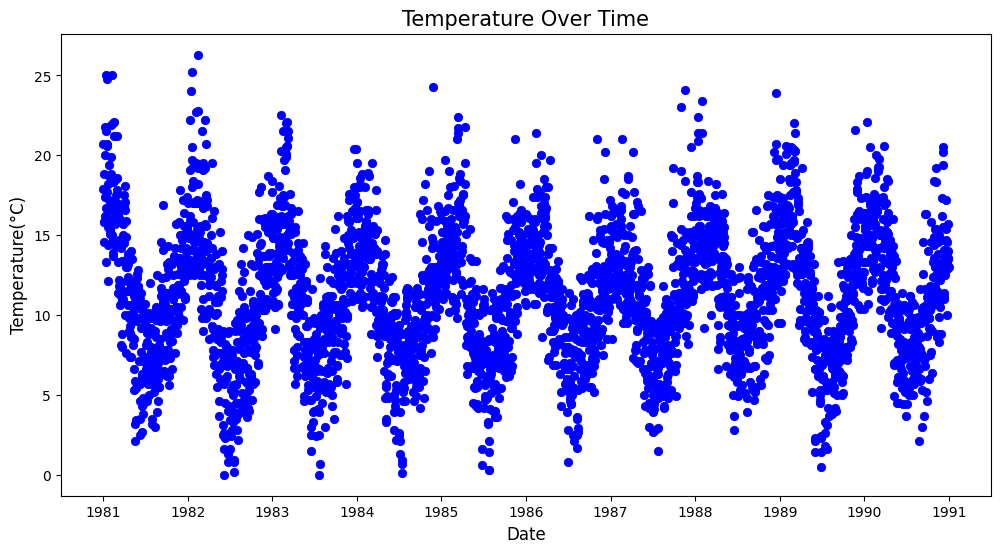

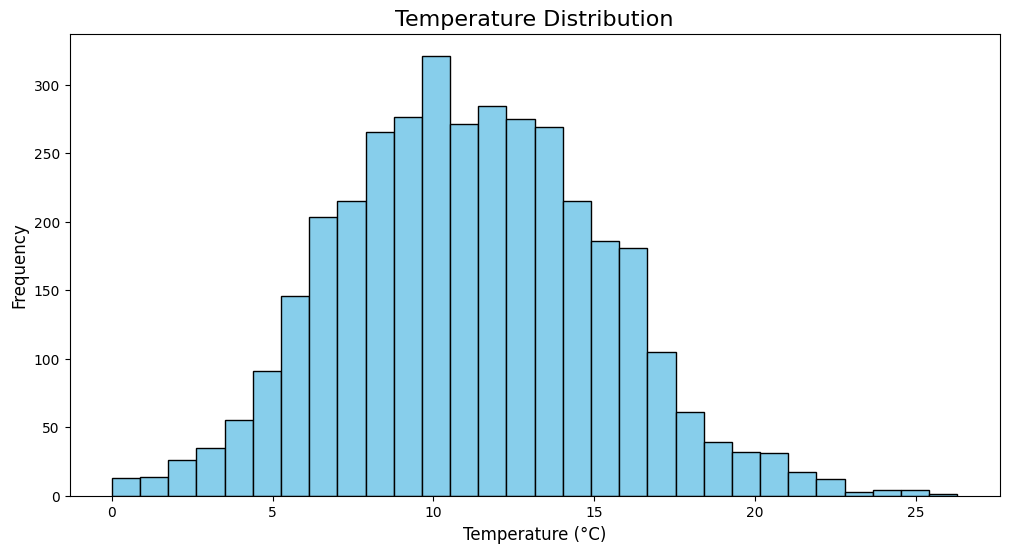

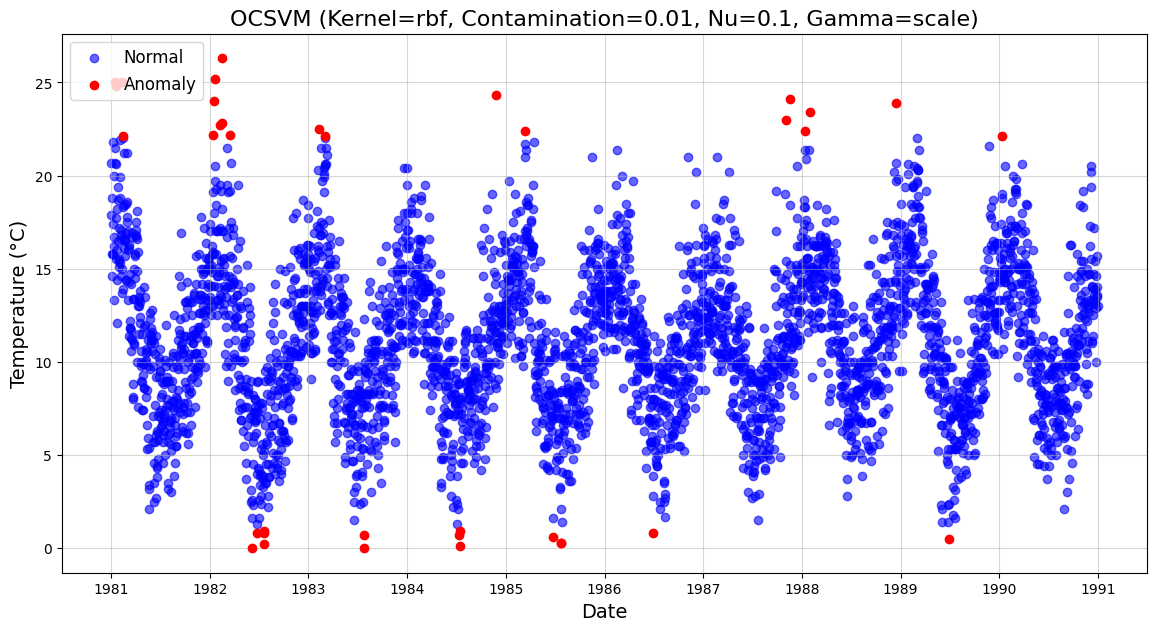

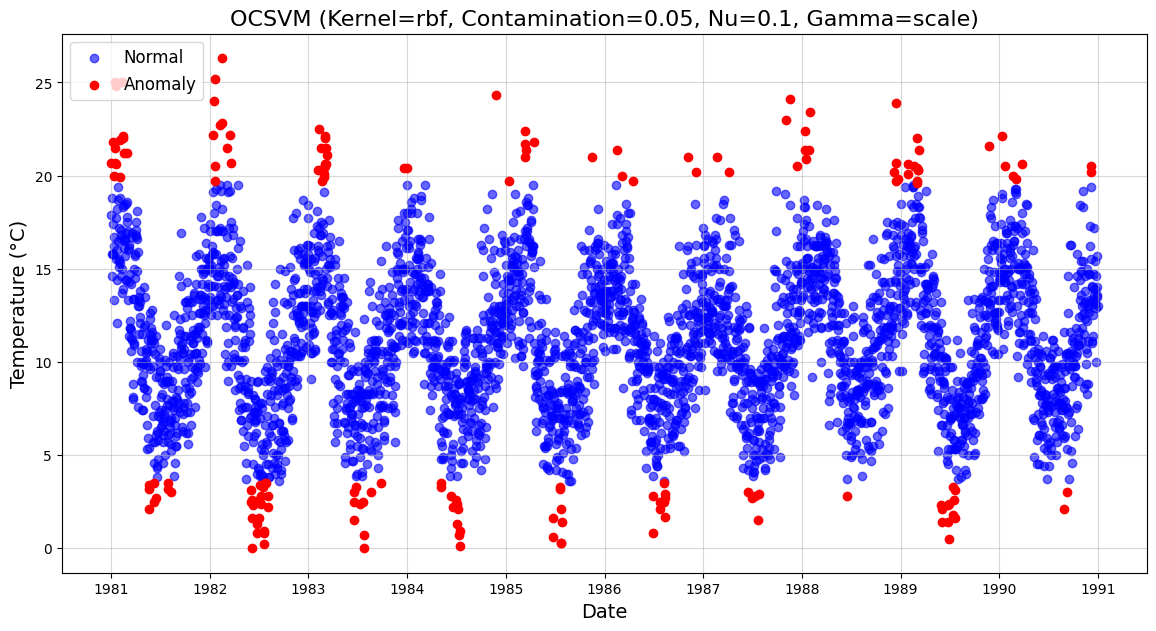

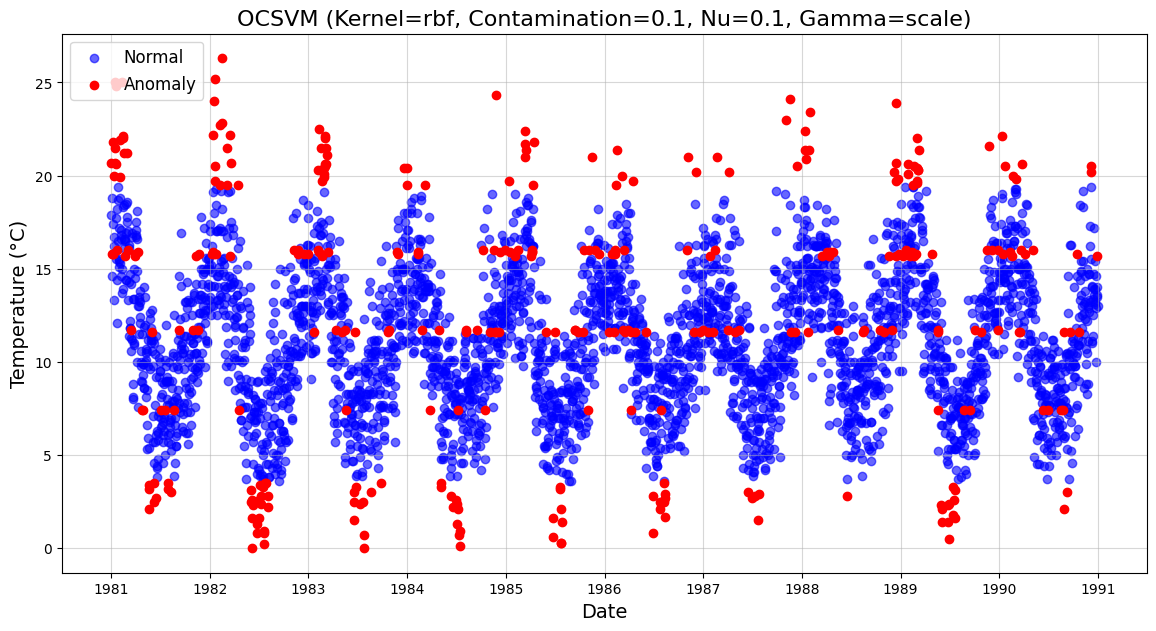

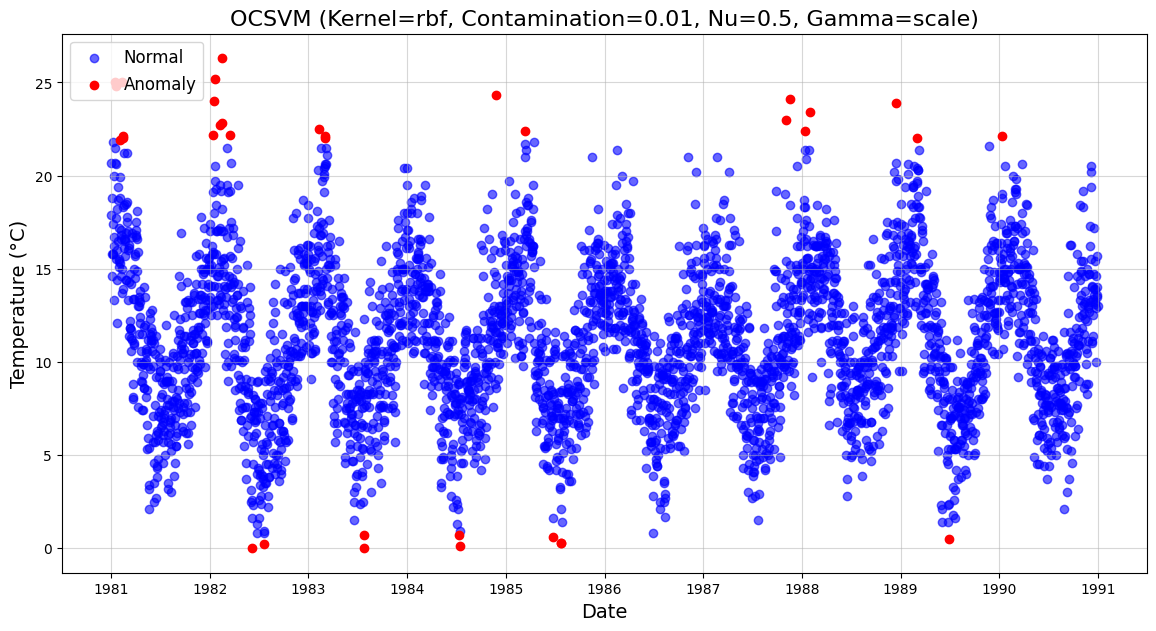

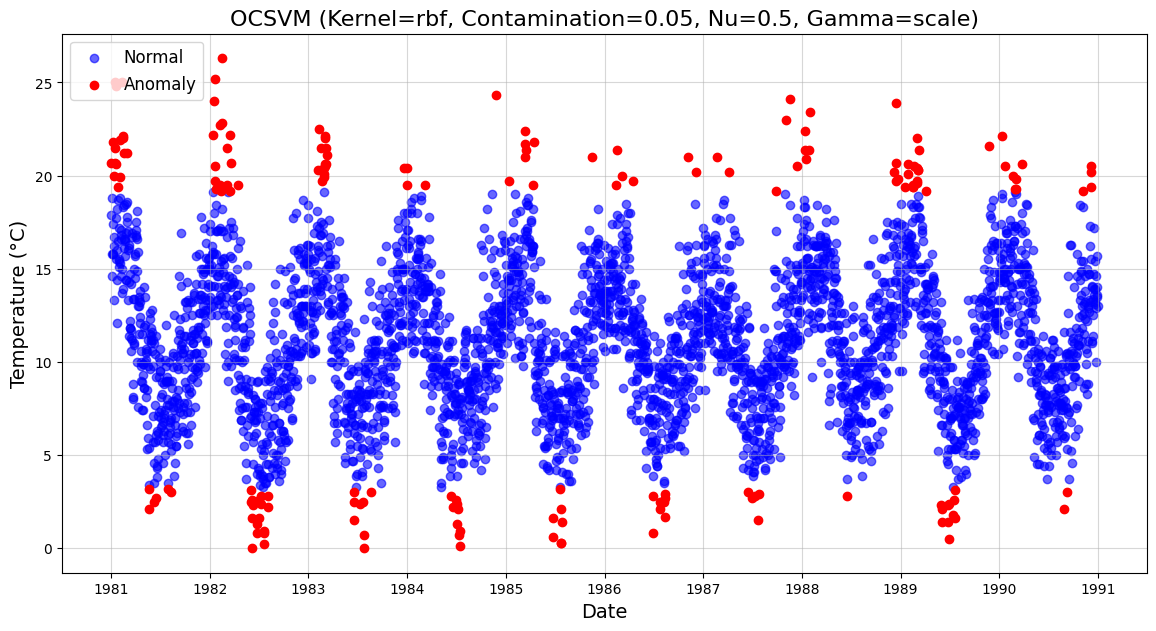

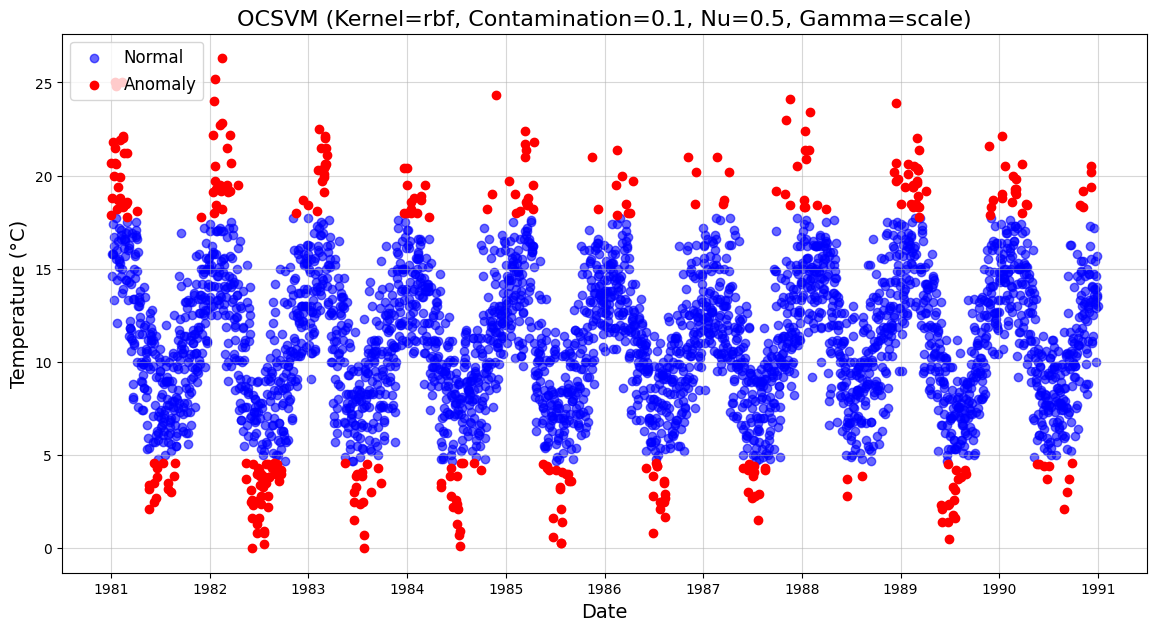

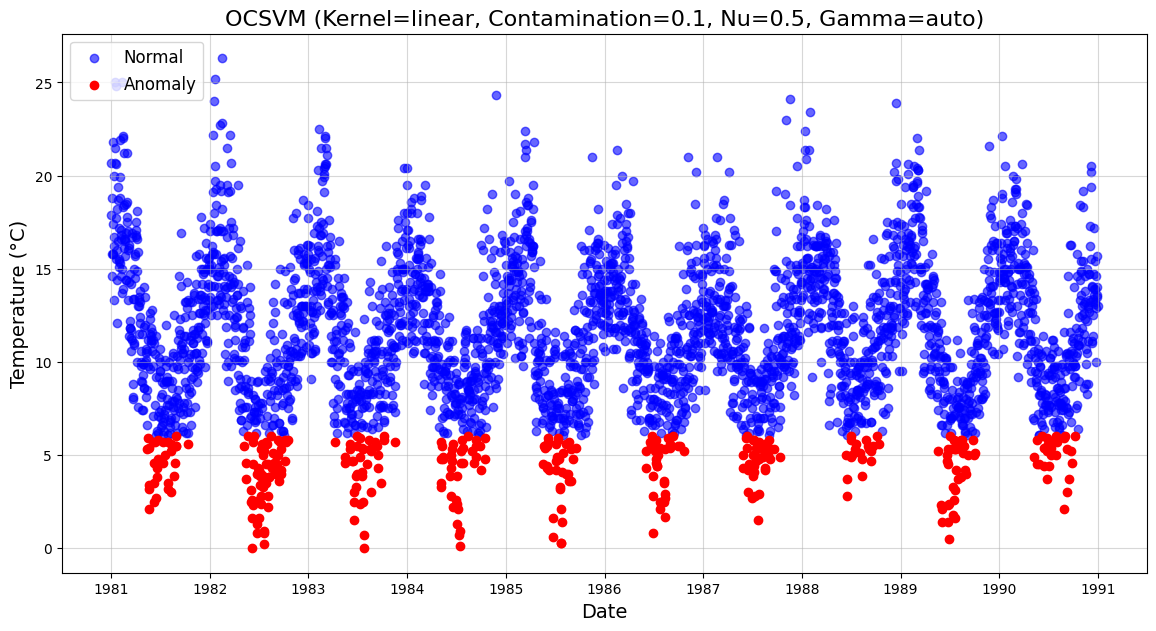

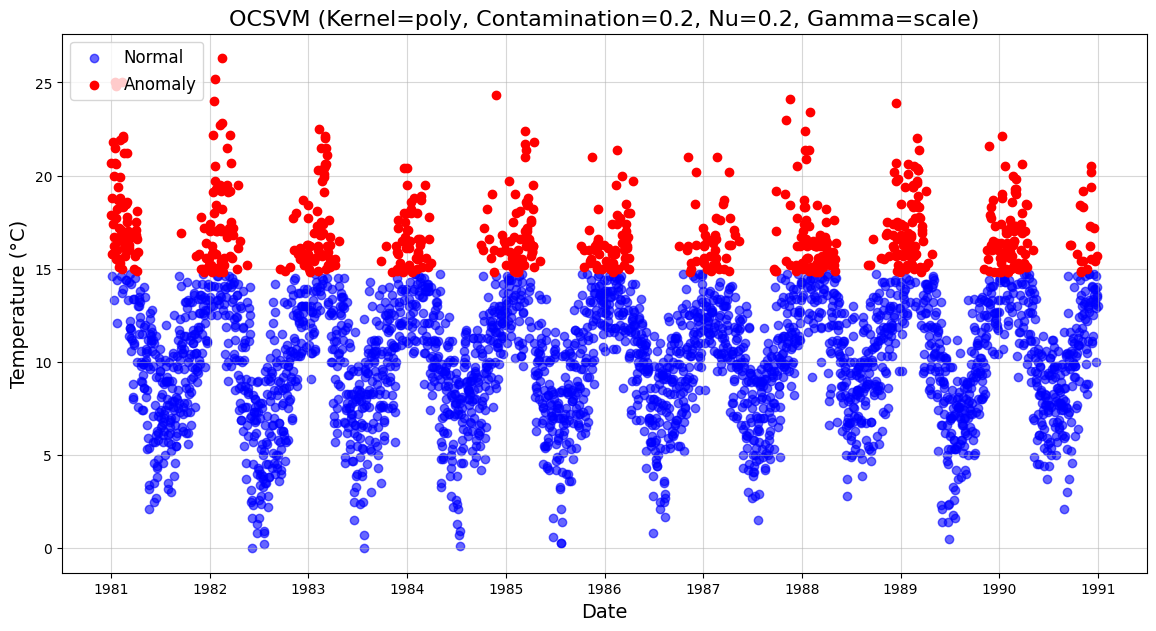




One Class SVM Results:

Configuration 1: {'contamination': 0.01, 'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'}
Accuracy: 0.9808
Precision: 0.0278
Recall-score: 0.0278
F1-Score: 0.0278

Configuration 2: {'contamination': 0.05, 'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'}
Accuracy: 0.9071
Precision: 0.0852
Recall-score: 0.0777
F1-Score: 0.0813

Configuration 3: {'contamination': 0.1, 'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'}
Accuracy: 0.8315
Precision: 0.1137
Recall-score: 0.1114
F1-Score: 0.1126

Configuration 4: {'contamination': 0.01, 'kernel': 'rbf', 'nu': 0.5, 'gamma': 'scale'}
Accuracy: 0.9811
Precision: 0.0286
Recall-score: 0.0278
F1-Score: 0.0282

Configuration 5: {'contamination': 0.05, 'kernel': 'rbf', 'nu': 0.5, 'gamma': 'scale'}
Accuracy: 0.9041
Precision: 0.0710
Recall-score: 0.0674
F1-Score: 0.0691

Configuration 6: {'contamination': 0.1, 'kernel': 'rbf', 'nu': 0.5, 'gamma': 'scale'}
Accuracy: 0.8274
Precision: 0.1089
Recall-score: 0.1114
F1-Score: 0.1102

Configura

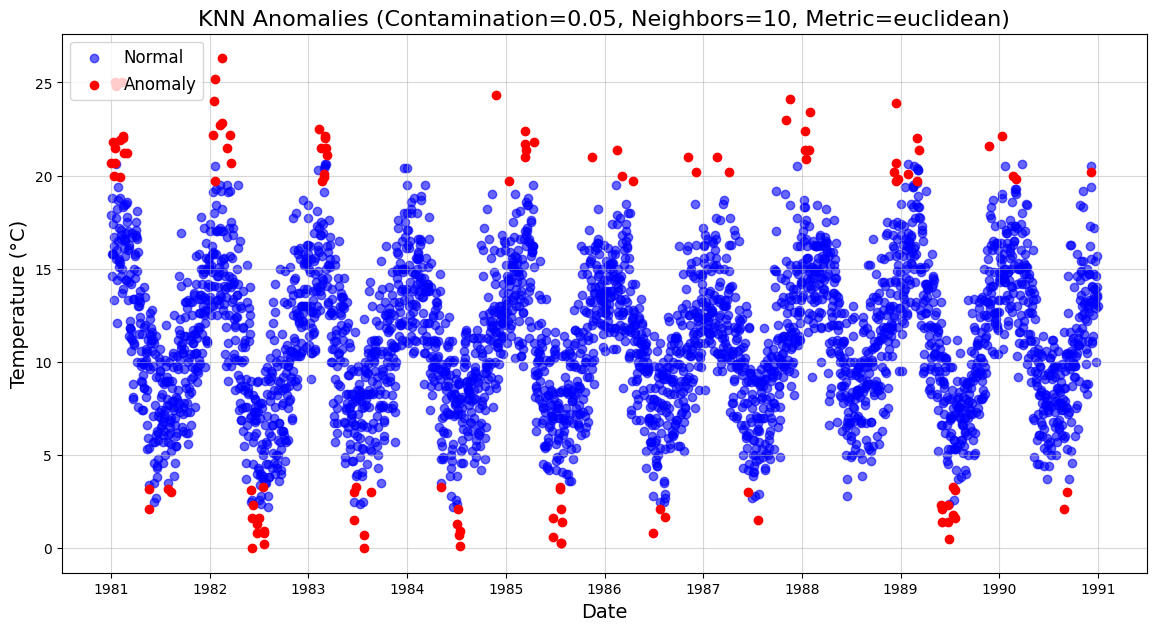

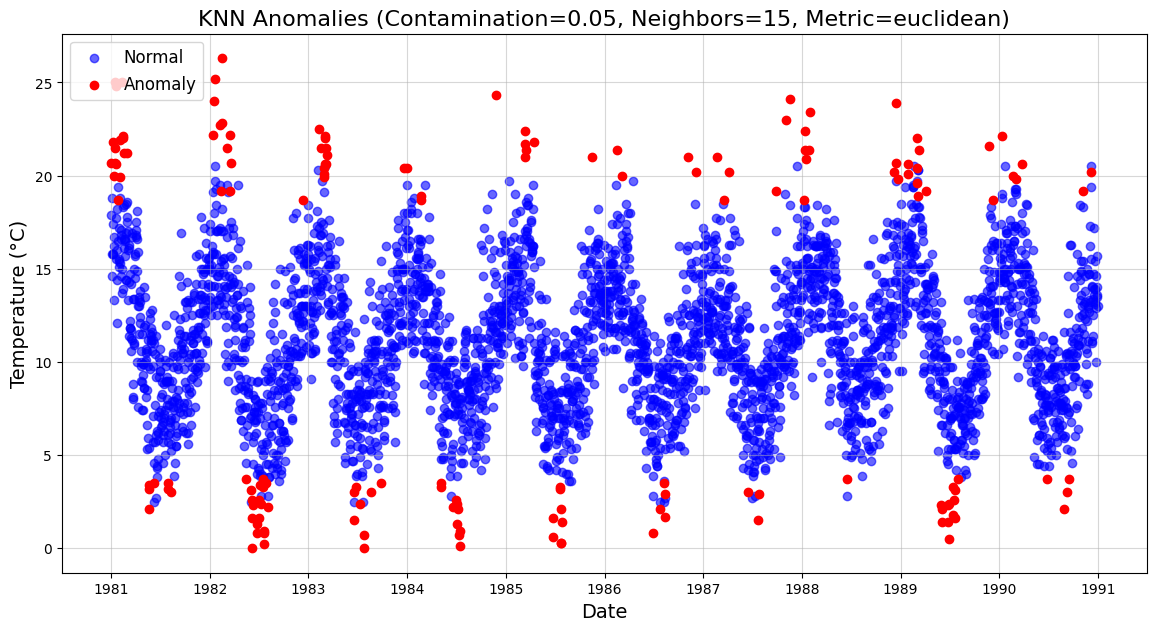

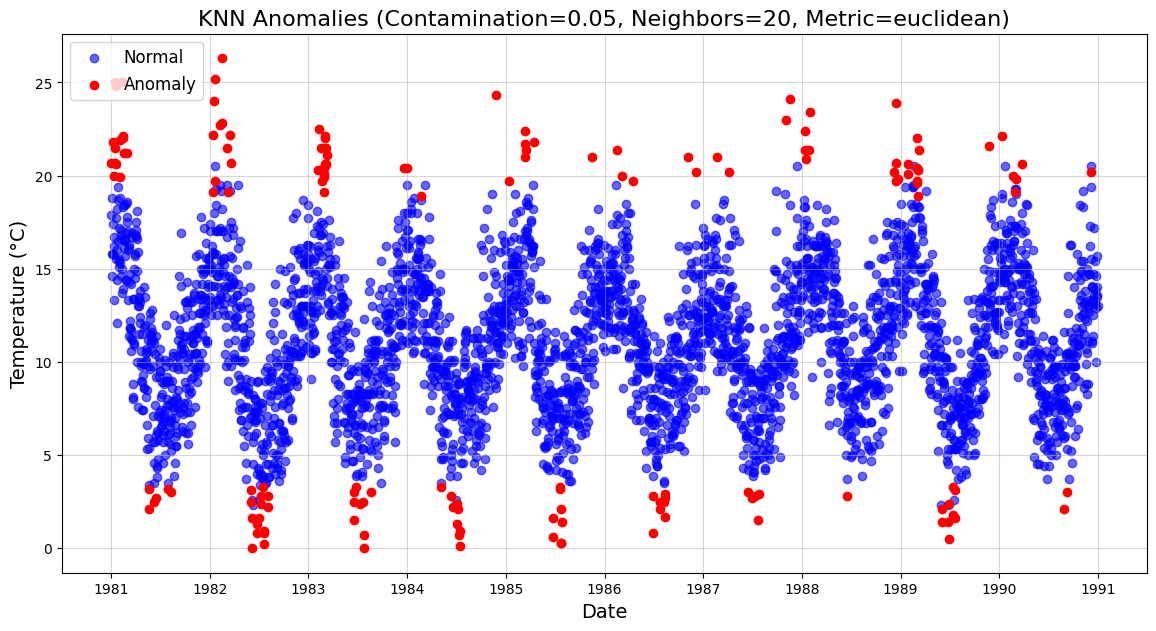

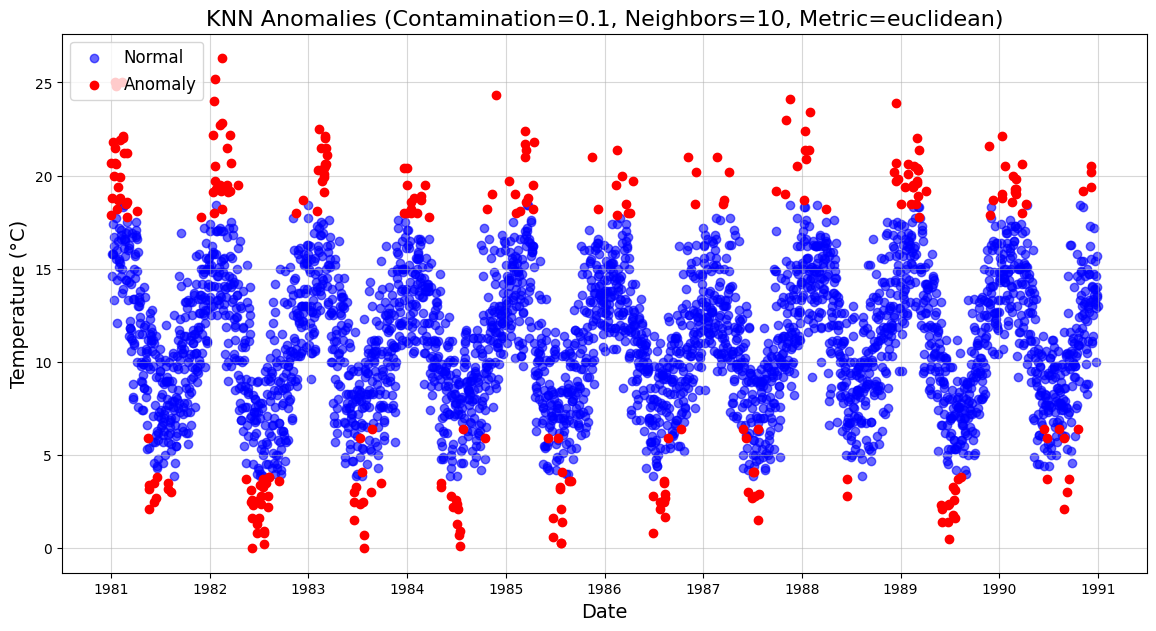

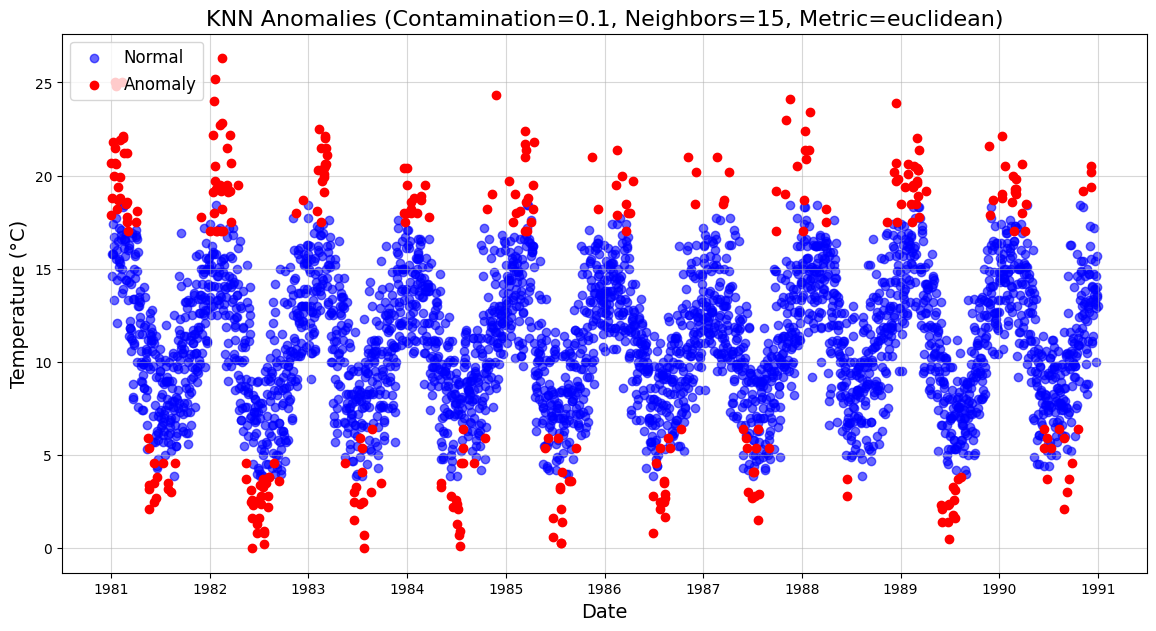

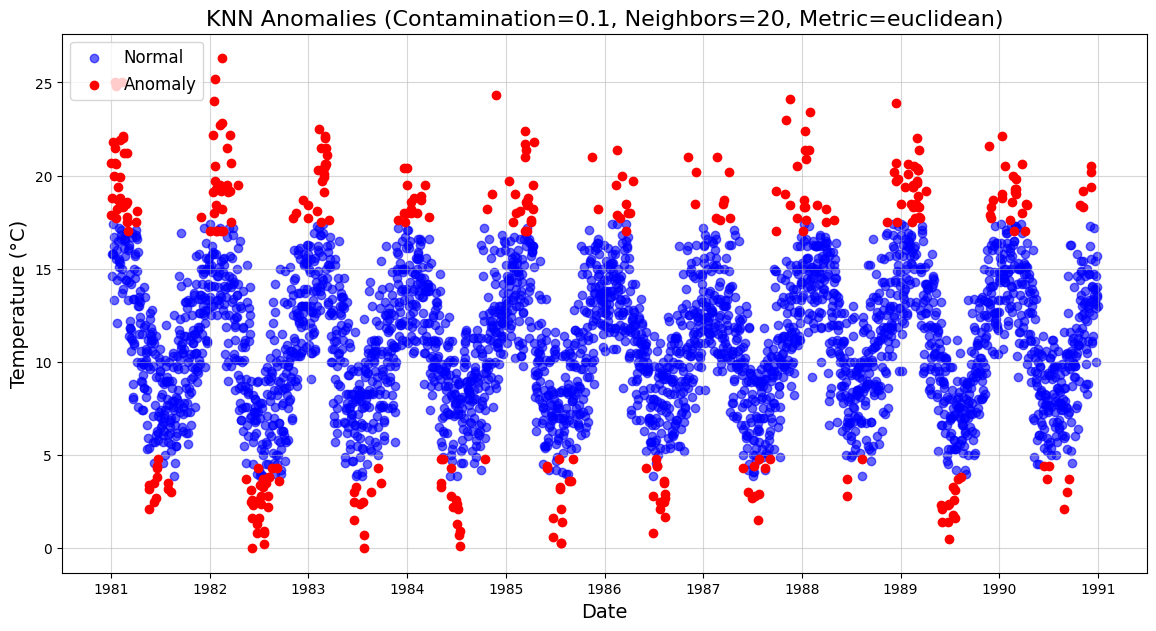

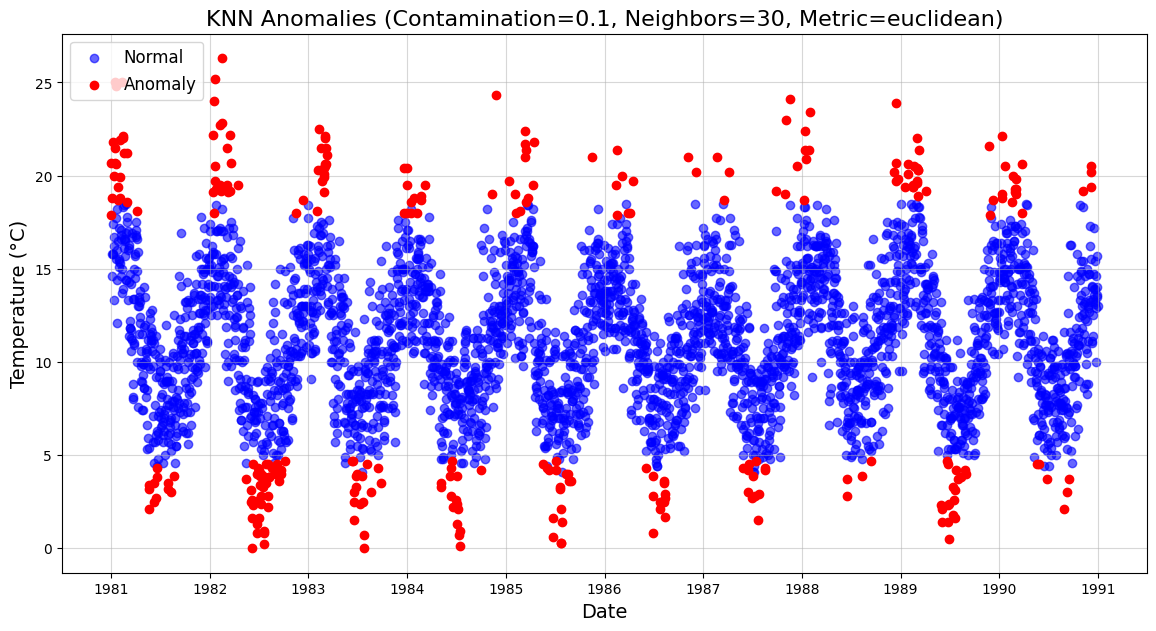

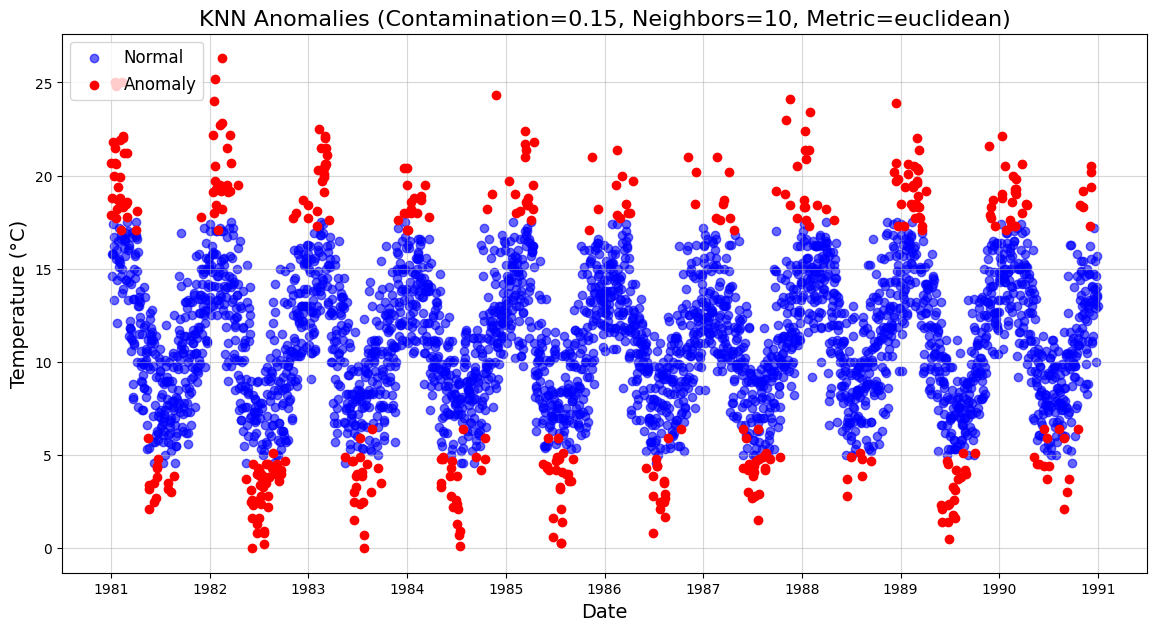

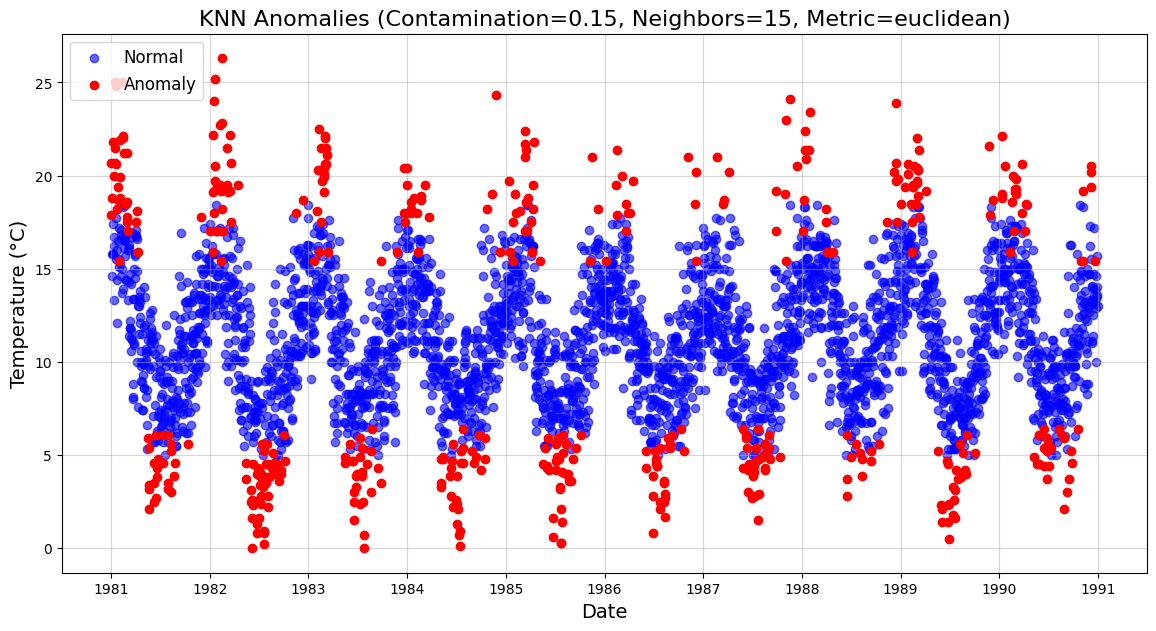

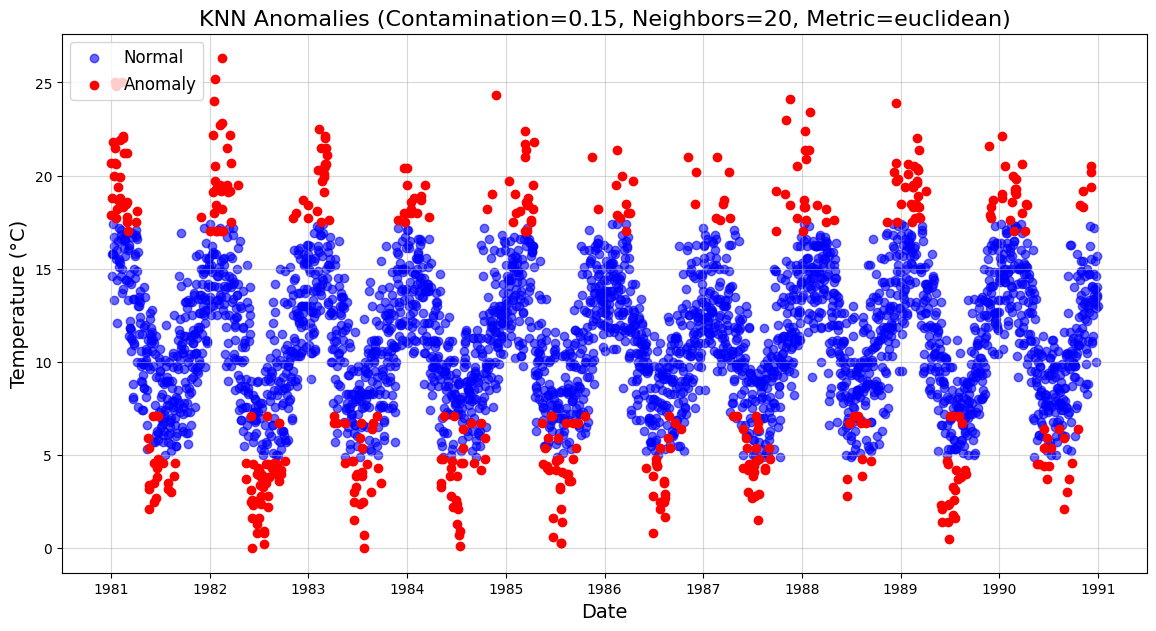

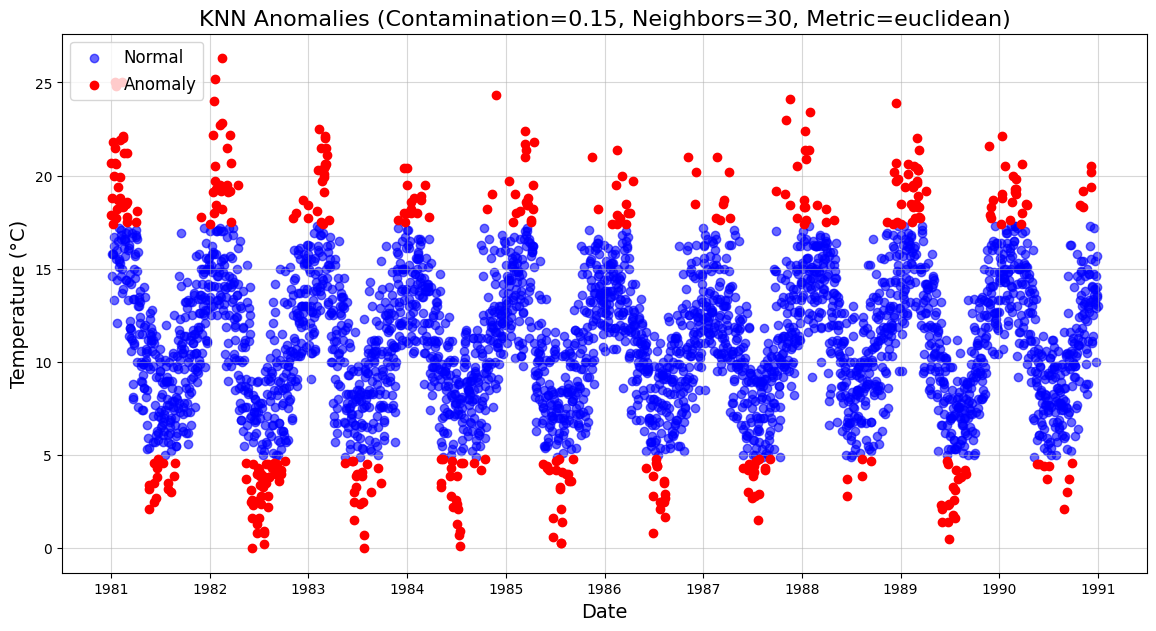




KNN Results:

Configuration 1: {'contamination': 0.05, 'n_neighbors': 10, 'metric': 'euclidean'}
Accuracy: 0.9195
Precision: 0.0826
Recall-score: 0.0518
F1-Score: 0.0637

Configuration 2: {'contamination': 0.05, 'n_neighbors': 15, 'metric': 'euclidean'}
Accuracy: 0.9112
Precision: 0.1030
Recall-score: 0.0881
F1-Score: 0.0950

Configuration 3: {'contamination': 0.05, 'n_neighbors': 20, 'metric': 'euclidean'}
Accuracy: 0.9099
Precision: 0.0750
Recall-score: 0.0622
F1-Score: 0.0680

Configuration 4: {'contamination': 0.1, 'n_neighbors': 10, 'metric': 'euclidean'}
Accuracy: 0.8441
Precision: 0.1263
Recall-score: 0.1057
F1-Score: 0.1151

Configuration 5: {'contamination': 0.1, 'n_neighbors': 15, 'metric': 'euclidean'}
Accuracy: 0.8345
Precision: 0.1265
Recall-score: 0.1229
F1-Score: 0.1246

Configuration 6: {'contamination': 0.1, 'n_neighbors': 20, 'metric': 'euclidean'}
Accuracy: 0.8299
Precision: 0.1204
Recall-score: 0.1229
F1-Score: 0.1216

Configuration 7: {'contamination': 0.1, 'n_n

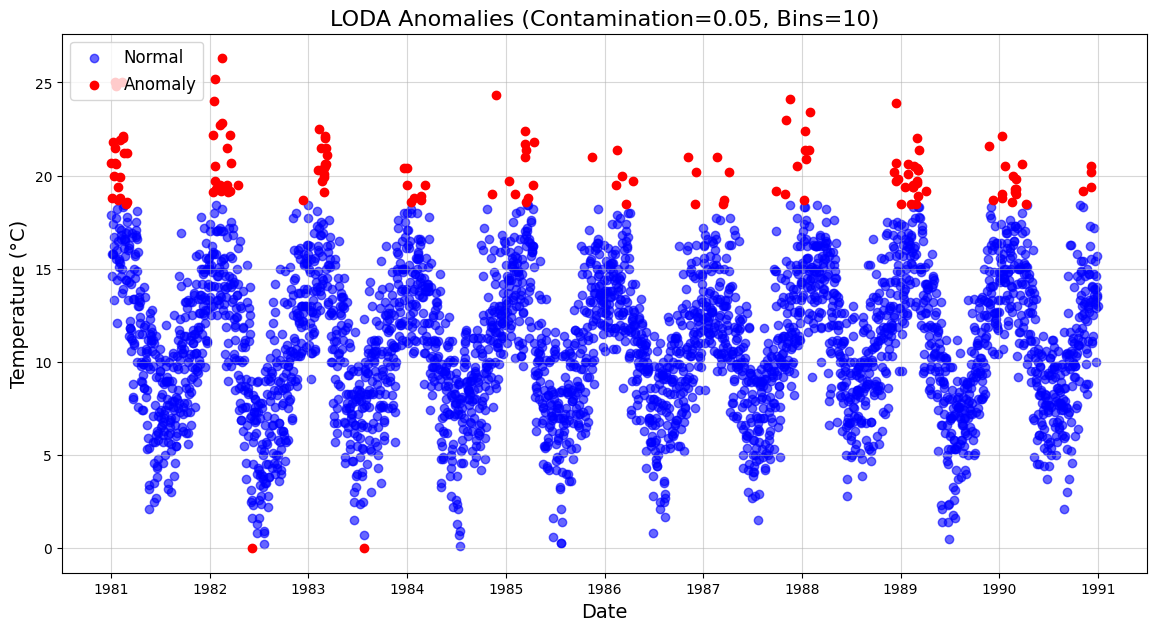

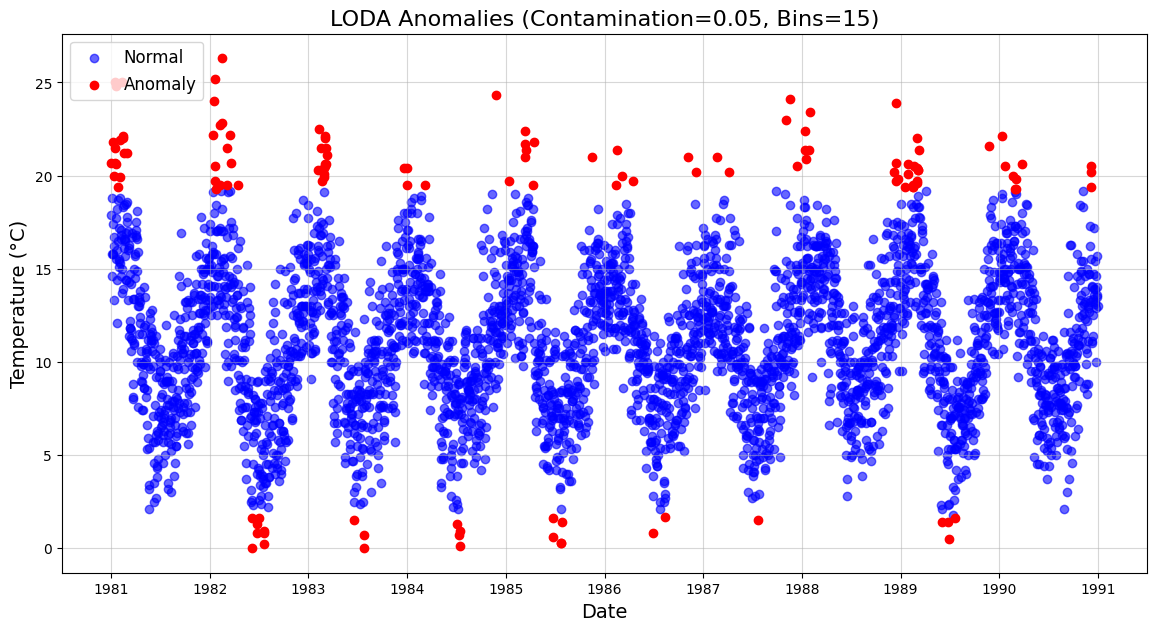

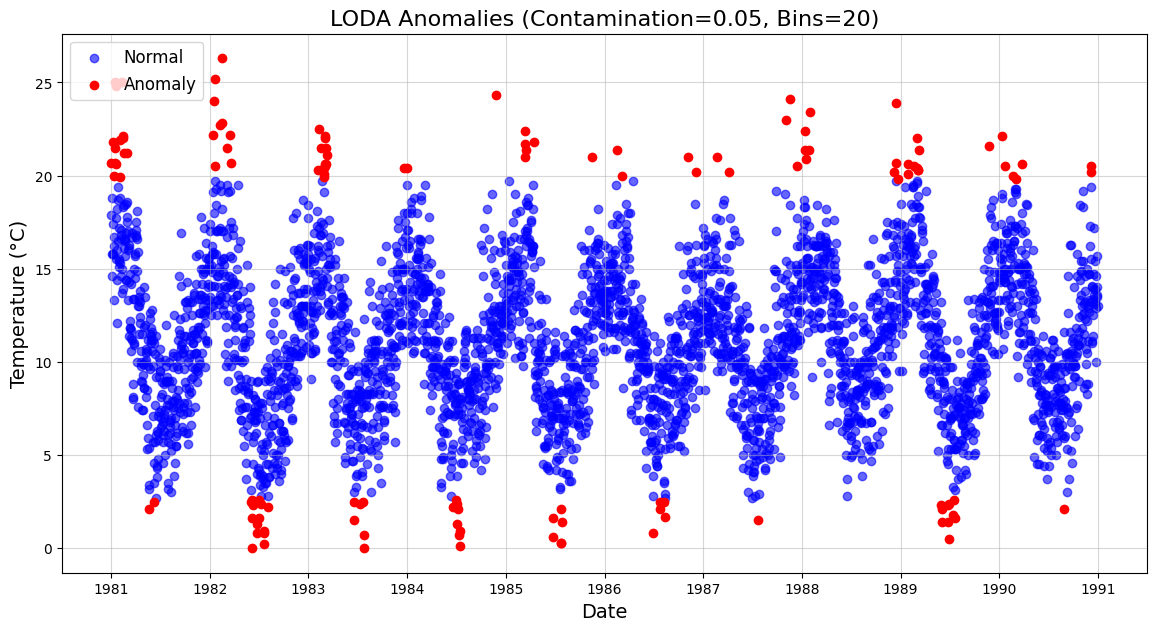

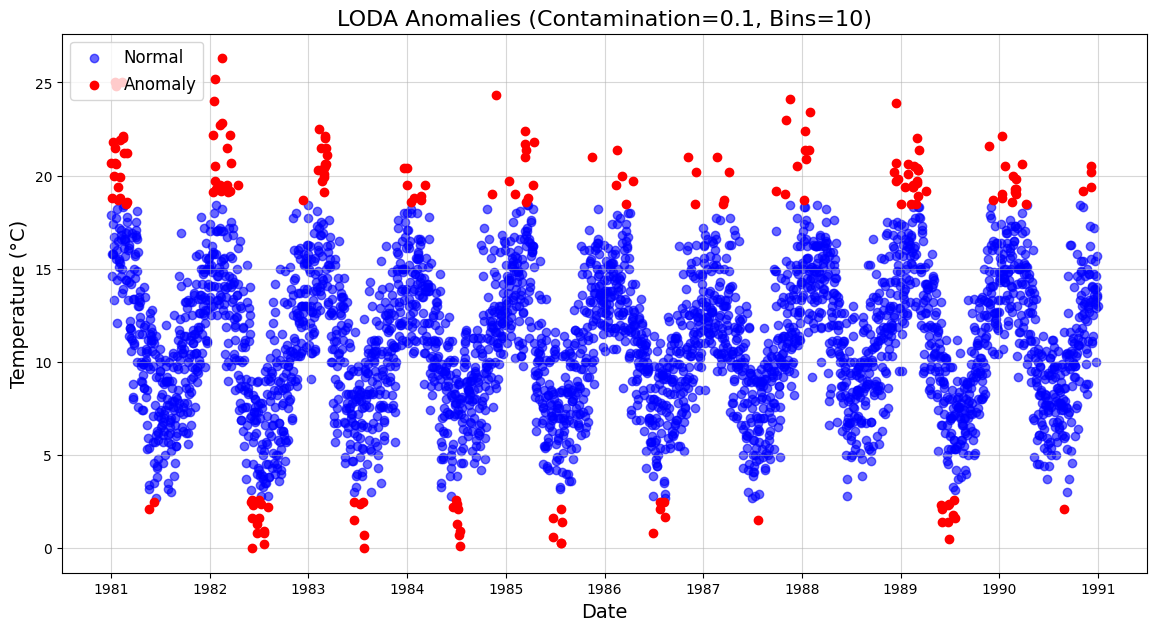

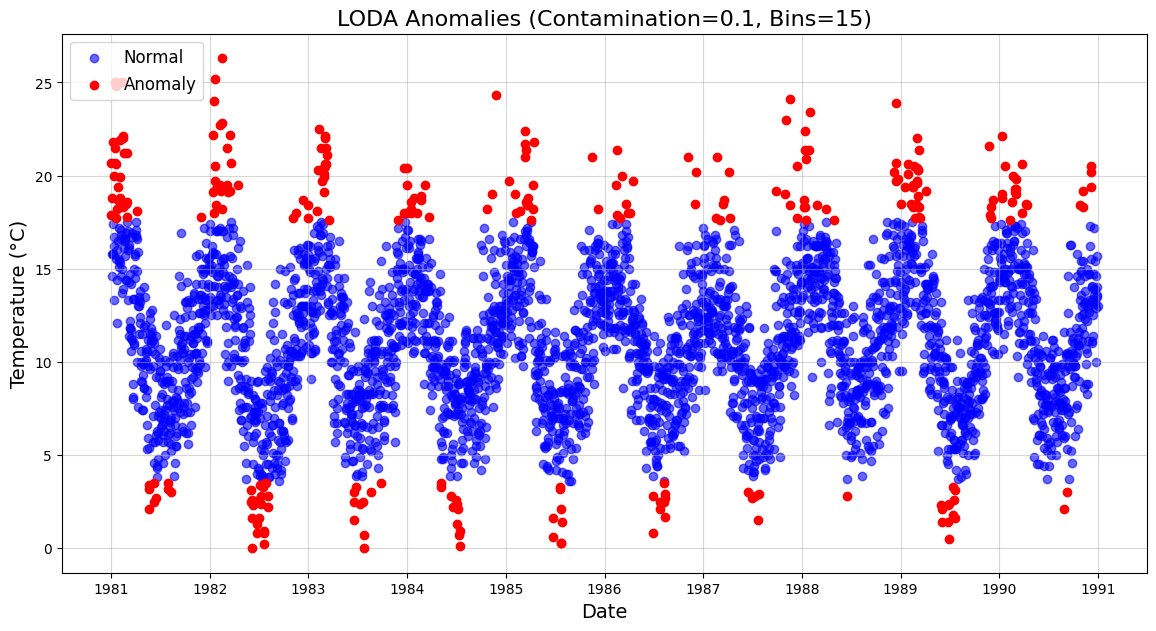

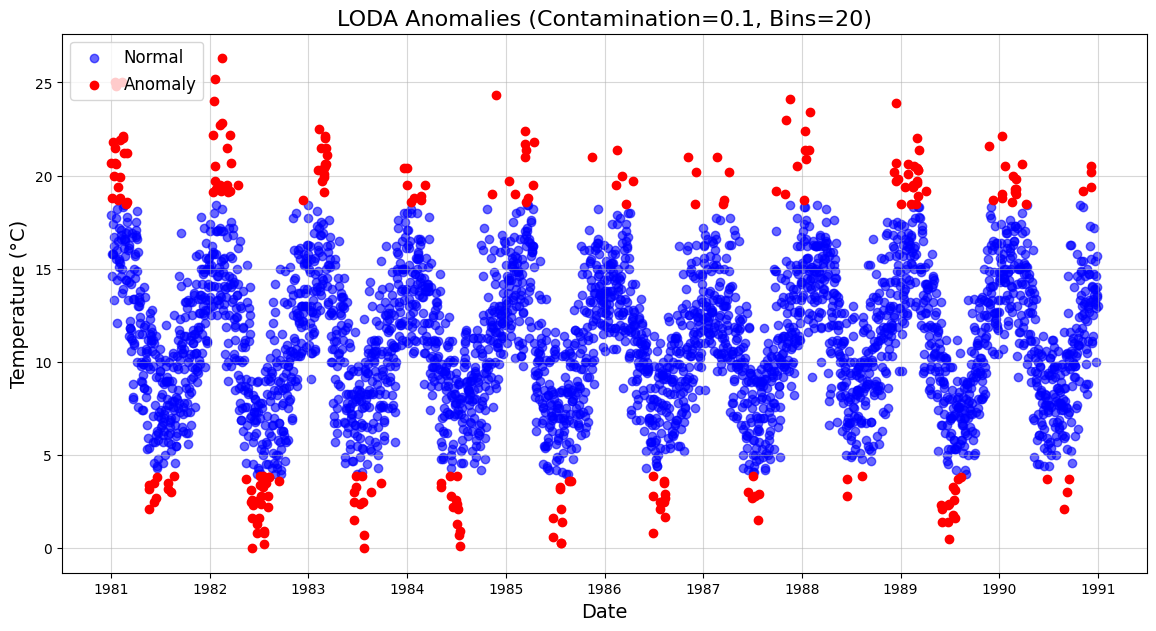

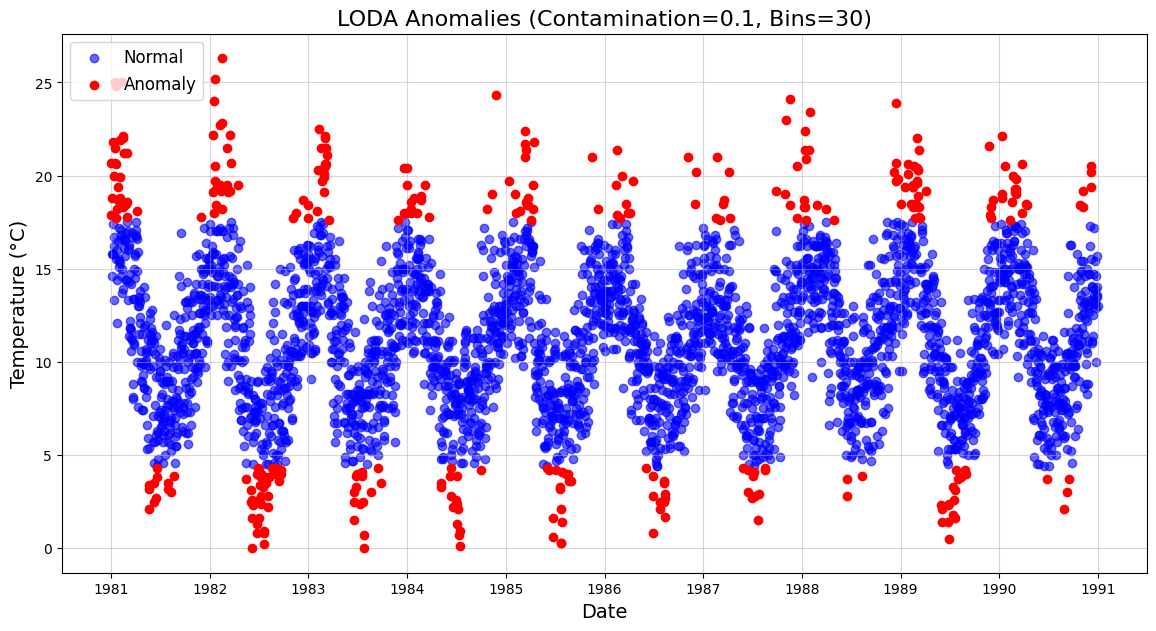

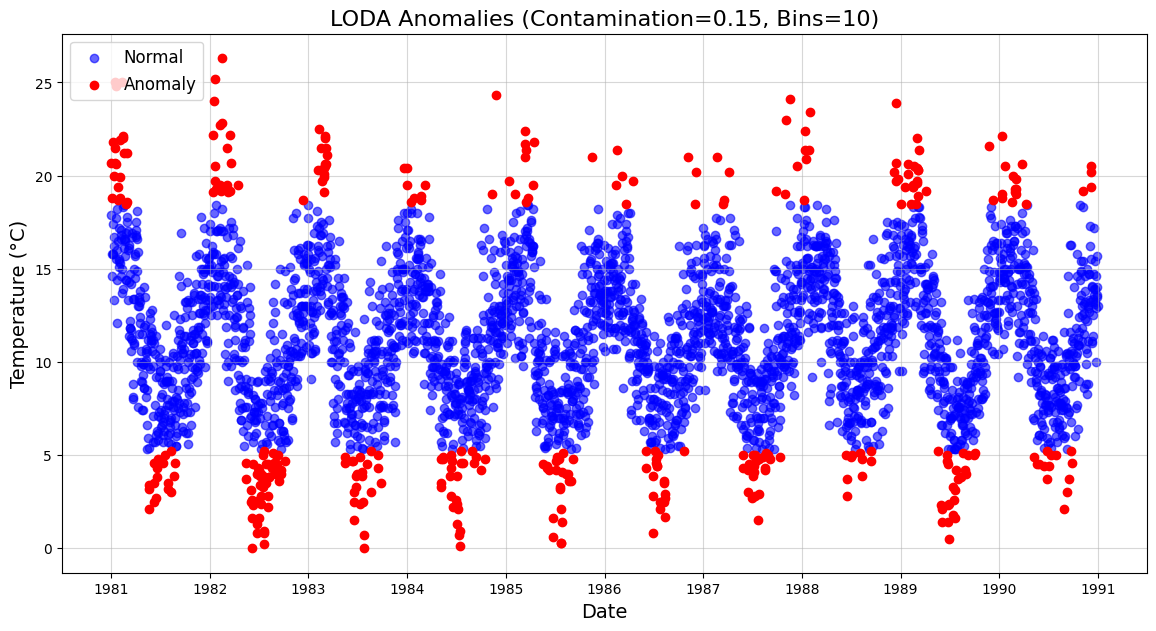

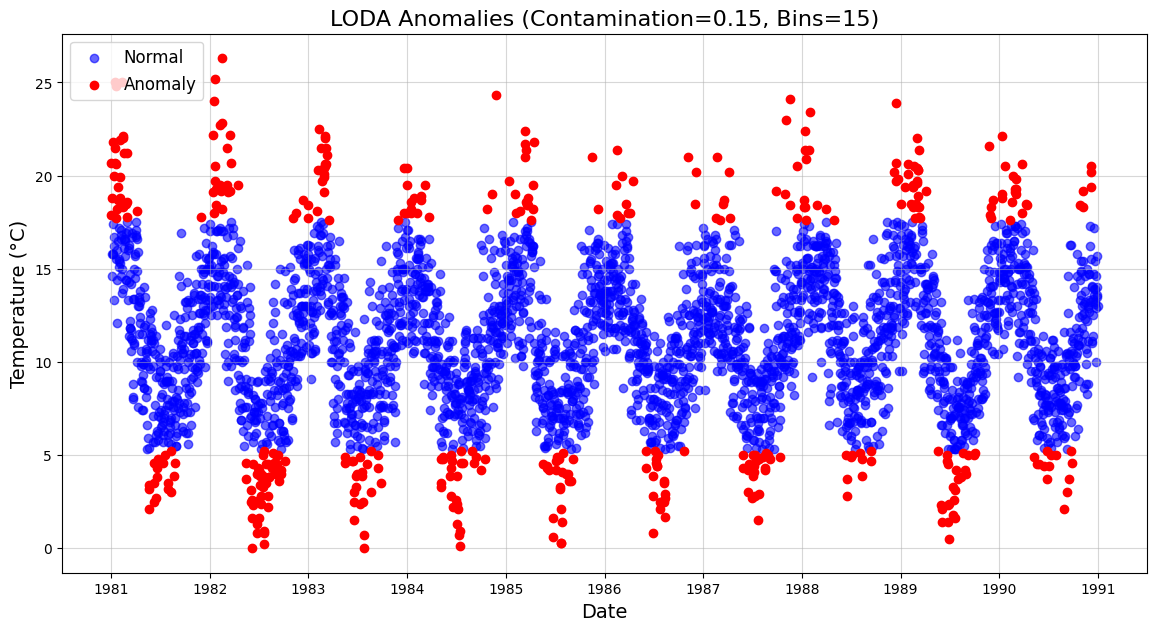

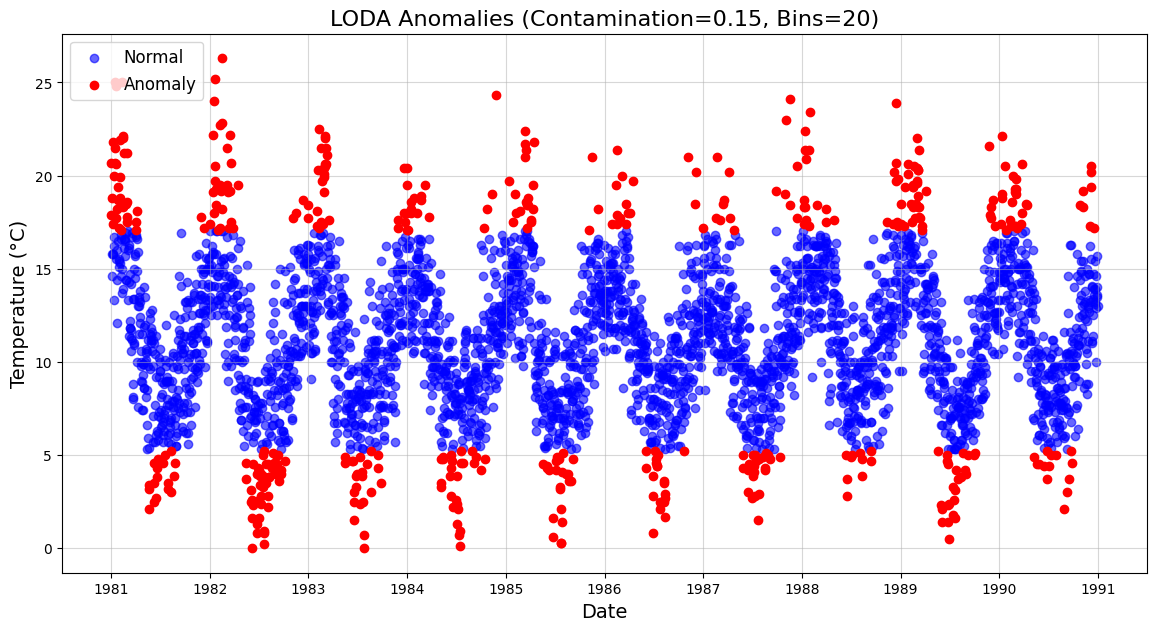

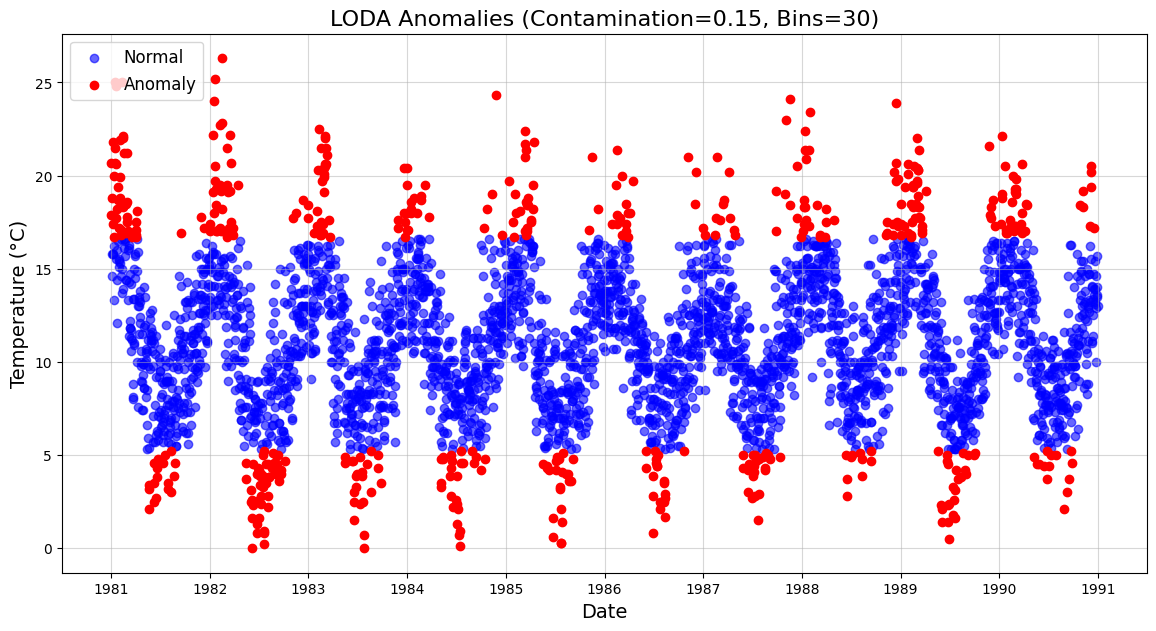




LODA Results:

Configuration 1: {'contamination': 0.05, 'n_bins': 10}
Accuracy: 0.9118
Precision: 0.0552
Recall-score: 0.0415
F1-Score: 0.0473

Configuration 2: {'contamination': 0.05, 'n_bins': 15}
Accuracy: 0.9156
Precision: 0.0611
Recall-score: 0.0415
F1-Score: 0.0494

Configuration 3: {'contamination': 0.05, 'n_bins': 20}
Accuracy: 0.9164
Precision: 0.0821
Recall-score: 0.0570
F1-Score: 0.0673

Configuration 4: {'contamination': 0.1, 'n_bins': 10}
Accuracy: 0.8636
Precision: 0.1224
Recall-score: 0.0686
F1-Score: 0.0879

Configuration 5: {'contamination': 0.1, 'n_bins': 15}
Accuracy: 0.8438
Precision: 0.1233
Recall-score: 0.1029
F1-Score: 0.1121

Configuration 6: {'contamination': 0.1, 'n_bins': 20}
Accuracy: 0.8518
Precision: 0.1255
Recall-score: 0.0914
F1-Score: 0.1058

Configuration 7: {'contamination': 0.1, 'n_bins': 30}
Accuracy: 0.8310
Precision: 0.1153
Recall-score: 0.1143
F1-Score: 0.1148

Configuration 8: {'contamination': 0.15, 'n_bins': 10}
Accuracy: 0.7795
Precision: 

In [21]:
if __name__ == "__main__":
    data = load_and_preprocess_data('daily-min-temperatures.csv')

    display_basic_statistics(data)
    plot_temperature_trend_and_temperature_distribution(data)

parameter_configs_svm = [
        {'contamination': 0.01, 'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'},
        {'contamination': 0.05, 'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'},
        {'contamination': 0.1, 'kernel': 'rbf', 'nu': 0.1, 'gamma': 'scale'},
        {'contamination': 0.01, 'kernel': 'rbf', 'nu': 0.5, 'gamma': 'scale'},
        {'contamination': 0.05, 'kernel': 'rbf', 'nu': 0.5, 'gamma': 'scale'},
        {'contamination': 0.1, 'kernel': 'rbf', 'nu': 0.5, 'gamma': 'scale'},
        {'contamination': 0.1, 'kernel': 'linear', 'nu': 0.5, 'gamma': 'auto'},
        {'contamination': 0.2, 'kernel': 'poly', 'nu': 0.2, 'gamma': 'scale'},
    ]

knn_params = [
    {'contamination': 0.05, 'n_neighbors': 10, 'metric': 'euclidean'},
    {'contamination': 0.05, 'n_neighbors': 15, 'metric': 'euclidean'},
    {'contamination': 0.05, 'n_neighbors': 20, 'metric': 'euclidean'},
    {'contamination': 0.1, 'n_neighbors': 10, 'metric': 'euclidean'},
    {'contamination': 0.1, 'n_neighbors': 15, 'metric': 'euclidean'},
    {'contamination': 0.1, 'n_neighbors': 20, 'metric': 'euclidean'},
    {'contamination': 0.1, 'n_neighbors': 30, 'metric': 'euclidean'},
    {'contamination': 0.15, 'n_neighbors': 10, 'metric': 'euclidean'},
    {'contamination': 0.15, 'n_neighbors': 15, 'metric': 'euclidean'},
    {'contamination': 0.15, 'n_neighbors': 20, 'metric': 'euclidean'},
    {'contamination': 0.15, 'n_neighbors': 30, 'metric': 'euclidean'},
]

loda_params=[
    {'contamination': 0.05, 'n_bins': 10},
    {'contamination': 0.05, 'n_bins': 15},
    {'contamination': 0.05, 'n_bins': 20},
    {'contamination': 0.1, 'n_bins': 10},
    {'contamination': 0.1, 'n_bins': 15},
    {'contamination': 0.1, 'n_bins': 20},
    {'contamination': 0.1, 'n_bins': 30},
    {'contamination': 0.15, 'n_bins': 10},
    {'contamination': 0.15, 'n_bins': 15},
    {'contamination': 0.15, 'n_bins': 20},
    {'contamination': 0.15, 'n_bins': 30},

]

evaluate_and_display_results(data,parameter_configs_svm,knn_params,loda_params)




#Evaluarea performantei si interpretarea rezultatelor.Concluzii
---
<br>

##Evaluarea performantei si interpretarea rezulatetlor pentru KNN:
###Din grafic se observa ca rezultatele optime se obtin pentru un numar mic de vecini,grad mic de contaminare si distanta euclidiana.
<br>

###Numar mic de vecini => modelul se va concentra pe date locale.Modelul va putea detecta rapid abaterile datelor.
<br>

###Distanta euclidiana => se va masura distanta "directa" dintre doua puncte si este buna intr-o strucutura similara a datelor cum ar fi temperaturile.

<br>

##Motive pentru nu da rezultate un numar mare de vecini:
###-Modelul va lua in considerare o parta mai mare de date ce poate duce la o detectare mai lenta a anomaliilor.

<br>

##Motive pentru care nu este buna distanta Manhattan:
###-Masoara distanta prin deplasarea pe cele doua axe,se foloseste de obicei pentru date care nu au o structura continua

<br>

###Minkowski este o generalize a distantei euclidiene si a celei manhattan,deci pentru valori mici ale lui p vor fi probleme asemanatoare Manhattan

<br>

---

##Evaluarea performantei si interpretarea rezulatetlor pentru OCSVM:
###Se observa ca folosirea unui kernel rbf functioneaza bine deoarece setul de date nu este liniar,kenelul fiind non-liniar.Se vor separa mai precis punctele normale de cele anormale printr-o anomalie mica <=0.15.

<br>

###Parametrul nu este important deoarece face presupuneri asupra numarul de anomalii prezente.Un nu mic garanteaza un numar mai realist de anomalii pentru setul meu de date.

<br>

##Motive pentru care nu da rezulate kernelul liniar:
###-Distributia datelor nu este liniara.
###-Dimensiunea redusa a caracterisitcilor pentru care facem clasificarea.

<br>

##Motive pentru care nu da rezultate kernelul polynomial:
###-Overfitting
###-Sensibil la zgomot,datele cu temperaturi pot avea varieri naturale care nu sunt favorabile metodei cu kernel polynomial.

<br>

---

##Evaluarea performantei si interpretarea rezulatetlor pentru LODA:

<br>

###În metoda LODA, histogramele sunt utilizate pentru a reprezenta distribuțiile datelor pe baza proiecțiilor aleatorii.

###Numărul de bins influențează capacitatea modelului de a împărți datele în grupuri distincte.

###Numarul mic de bins => histograma va fi mai generala,anomaliile fiind usor de detectat,mai ales ca sunt izolate.Numarul de bins mai putine ajuta la un model simplu si eficient.

<br>

##Motive pentru care nu este bun un numar mare de bins:
###-Când numărul de bins este prea mare, modelul poate deveni prea detaliat, iar minoritățile din setul de date pot fi pierdute sau amestecate cu majoritatea datelor normale. Anomaliile subtile nu vor fi detectate eficient, iar procesul poate duce la overfitting.

<br>

---

##Concluziile metodelor folosite:

###În cazul seturilor cu anomalii rare și izolate (precum temperaturile zilnice), metodele precum OCSVM cu kernel RBF, KNN cu un număr mic de vecini și LODA cu contaminare mică sunt de obicei cele mai eficiente.

<br>

###Este esențial să se ajusteze parametrii cu atenție, să se utilizeze tehnici de evaluare corecte și să se țină cont de tipologia datelor pentru a maximiza performanța modelului de detectare a anomaliilor.

<br>



#Bibliografie

## https://pyod.readthedocs.io/en/latest/
## https://machinelearningmastery.com/time-series-datasets-for-machine-learning/